In [18]:
%matplotlib inline
import numpy as np
import openmc

In [19]:
#create materials

#fuel
fuel = openmc.Material(1, "Am242m")
fuel.add_nuclide('Am242_m1',1)
fuel.set_density('g/cm3',13.6)
print(fuel)

#fuel with realistic enrichment (low density to simulate dispersed particles in aerogel)
fuel2 = openmc.Material(11, "Am242m less enriched")
fuel2.add_nuclide('Am242_m1', .3)
fuel2.add_nuclide('Am241', .7)
fuel2.set_density('g/cm3', .136)
print(fuel2)

#moderator
BeO = openmc.Material(2, "BeO")
BeO.add_nuclide("Be9", .5)
BeO.add_nuclide("O16", .5)
BeO.set_density("g/cm3", 2.86)
print(BeO)

#Be moderator
Be = openmc.Material(7, "Be")
Be.add_nuclide("Be9", 1.0)
Be.set_density("g/cm3", 1.85)
print(Be)

#"vacuum"
vac = openmc.Material(10, "H1")
vac.add_nuclide('H1',1.0)
vac.set_density('g/cm3',0.000001)
print(vac)

#reflector
#may add a reflector in the future. for now just BeO moderator

Material
	ID             =	1
	Name           =	Am242m
	Temperature    =	None
	Density        =	13.6 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Am242_m1       =	1            [ao]

Material
	ID             =	11
	Name           =	Am242m less enriched
	Temperature    =	None
	Density        =	0.136 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Am242_m1       =	0.3          [ao]
	Am241          =	0.7          [ao]

Material
	ID             =	2
	Name           =	BeO
	Temperature    =	None
	Density        =	2.86 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	0.5          [ao]
	O16            =	0.5          [ao]

Material
	ID             =	7
	Name           =	Be
	Temperature    =	None
	Density        =	1.85 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	1.0          [ao]

Material
	ID             =	10
	Name           =	H1
	Temperature    =	None
	Density        =	1e-06 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	H1             =	1.0          [ao]



/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=11.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=7.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=10.
  warn(msg, IDWarning)


In [52]:
# Outer radius of fuel
fuel_outer = 2.5 #cm fuel outer radius
fuel_thickness = .1
fuel_inner = fuel_outer - fuel_thickness #inner radius for 2micron fuel layer

# parameters for depth of various things
fuel_depth = 30 #depth of fuel/moderator disk
ref_depth =  #depth of top reflecting/moderating layer

#edge length of hexagonal fuel cell
mod_thickness = 3
hex_dis = fuel_outer + mod_thickness
edge = hex_dis * 2 / np.sqrt(3)

#outer radius of fuel disk
disk_outer = 80 # radius in cm

In [53]:
#define a cell surface for a single fuel cylinder
f_inner_surf = openmc.ZCylinder(R=fuel_inner, boundary_type="transmission")
f_outer_surf = openmc.ZCylinder(R=fuel_outer, boundary_type="transmission")
f_lower_surf = openmc.ZPlane(z0=0, boundary_type="vacuum")
f_upper_surf = openmc.ZPlane(z0=fuel_depth, boundary_type="transmission")
m_upper_surf = openmc.ZPlane(z0=fuel_depth+ref_depth, boundary_type="vacuum")

outer_bound = openmc.ZCylinder(R=disk_outer+2*hex_dis, boundary_type="vacuum")

hex_region = openmc.get_hexagonal_prism(edge_length=edge, orientation='x', boundary_type="transmission")

hex_mod = +f_upper_surf & -m_upper_surf & hex_region
hex_edge = +f_lower_surf & -m_upper_surf & hex_region

fuel_region = -f_outer_surf & +f_inner_surf & -f_upper_surf & +f_lower_surf
mod_region = +f_outer_surf & -f_upper_surf & + f_lower_surf & hex_region | hex_mod
vac_region = ~fuel_region&~mod_region

#fill the fuel region
f=openmc.Cell(1, 'fuel')
f.fill=fuel2
f.region=fuel_region

#fill the moderator regions
m = openmc.Cell(2, 'moderator region 1')
m.fill=BeO
m.region=mod_region

medge = openmc.Cell(4, 'full plug hex')
medge.fill = BeO
medge.region = hex_edge

v = openmc.Cell(6, 'vacuum')
v.fill = vac
v.region = vac_region

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=6.
  warn(msg, IDWarning)


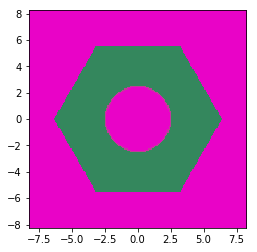

In [54]:
#visualize the fuel geometry
f_univ = openmc.Universe(cells=[f, m, v])
f_univ.plot(width=(3*hex_dis, 3*hex_dis), origin = (0,0,fuel_depth/2), basis='xy')

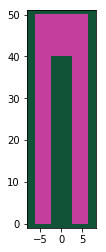

In [55]:
f_univ.plot(width=(3*hex_dis, fuel_depth+ref_depth+2), origin = (0, 0, (fuel_depth+ref_depth)/2), basis='xz')

In [56]:
edge_plug = openmc.Universe(cells=[medge])

In [57]:
#define the outer universe
out_reg = +f_lower_surf & -m_upper_surf & -outer_bound
out = openmc.Cell(7, 'outer universe cell')
out.region = out_reg
out.fill = vac
outer_uni = openmc.Universe(cells=[out])

#create a hexagonal lattice geometry
hexag = openmc.HexLattice()
hexag.center = (0,0)
hexag.pitch = [2*hex_dis]
hexag.outer = outer_uni


#construct the fuel cell specification
#iterate the number of rings so to fill up disk cylinder
rings = 0
while 2*rings*2*hex_dis < 2*disk_outer:
    rings=rings+1

u = []
for i in range(rings,0,-1):
    if i == 1:
        num = 1
    else:
        num = (i-1)*6
    fill = []
    for j in range(0,num):
        if i == rings:
            fill.append(edge_plug)
        else:
            fill.append(f_univ)
    u.append(fill)

hexag.universes = u

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=7.
  warn(msg, IDWarning)


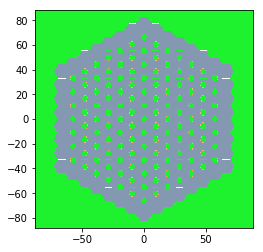

In [58]:
hex_cell = openmc.Cell(name='fuel disk')
hex_cell.fill = hexag

# Create final universe
uni = openmc.Universe(name='uni')
uni.add_cell(hex_cell)
uni.region = -outer_bound & +f_lower_surf & -m_upper_surf


uni.plot(width=(2.2*disk_outer, 2.2*disk_outer), origin = (0,0,(fuel_depth+ref_depth)/2), basis='xy', color_by='material')

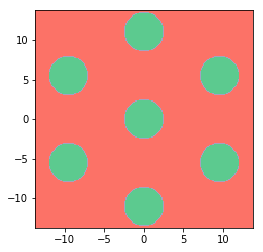

In [59]:
#zoom in
uni.plot(width=(5*hex_dis, 5*hex_dis), basis='xy', color_by='material')

In [60]:
#create root universe
geom = openmc.Geometry()
geom.root_universe = uni

#configure statistics geometry
#source = openmc.stats.Box((-20, -20, 0), (20, 20, fuel_depth))
source = openmc.stats.Point((fuel_inner+(fuel_outer-fuel_inner)/2, 0, 1))
src = openmc.Source(space=source)

#export geometry
geom.export_to_xml()

In [61]:
#create materials & cross sections xmls
mats = openmc.Materials()
mats.cross_sections = '/home/james/nndc_hdf5/cross_sections.xml' #comment this out/replace if you need to
mats.append(fuel)
mats += [fuel2]
mats += [BeO]
mats += [Be]
mats += [vac]

#export materials
mats.export_to_xml()

In [62]:
settings = openmc.Settings()
settings.particles = 5000
settings.batches = 30
settings.inactive = 10
settings.source = src
settings.export_to_xml()

In [63]:
#configure tallies
cell_filter = openmc.CellFilter(f)
t = openmc.Tally(4)
t.filters = [cell_filter]
t.scores = ['fission']
tallies = openmc.Tallies([t])

#export tallies
tallies.export_to_xml()

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Tally instance already exists with id=4.
  warn(msg, IDWarning)


In [64]:
openmc.run()

openmc: Relink `/home/james/anaconda3/bin/../lib/./libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               ####################

        3/1    0.95833                       
        4/1    0.90954                       
        5/1    0.88522                       
        6/1    0.86944                       
        7/1    0.85538                       
        8/1    0.90893                       
        9/1    0.86809                       
       10/1    0.85637                       
       11/1    0.90163                       
       12/1    0.86021    0.88092 +/- 0.02071
       13/1    0.88624    0.88269 +/- 0.01209
       14/1    0.87774    0.88146 +/- 0.00864
       15/1    0.89640    0.88445 +/- 0.00733
       16/1    0.85583    0.87968 +/- 0.00765
       17/1    0.86959    0.87823 +/- 0.00663
       18/1    0.84897    0.87458 +/- 0.00680
       19/1    0.88416    0.87564 +/- 0.00609
       20/1    0.86489    0.87457 +/- 0.00556
       21/1    0.85734    0.87300 +/- 0.00526
       22/1    0.86438    0.87228 +/- 0.00486
       23/1    0.88793    0.87349 +/- 0.00463
       24/1    0.88103    0.87402 

-6

In [65]:
def rep_cyl_mass(rings, fuel_depth, fuel_outer, edge_length, ref_depth, mod_dens) :
    """
    Calculates the mass of a repeating cylinder geometry
    
    Inputs:
    Rings: number of rings of fuel/moderator hexagonal prisms
    fuel_depth: height of the fuel/moderator section
    fuel_outer: outer radius of fuel layer
    edge_length: edge length of hexagonal prisms
    ref_depth: height of moderator layer
    mod_dens: density in g/cm3 of moderating material
    
    Outputs:
    mass: mass of the engine in kg
    """
    
    mod_plugs = rings * 6 #number of hexagonal prisms filled just with moderator
    fuel_plugs = 1 #number of hexagonal prisms with moderator, fuel, & vacuum
    for i in range(1, rings) : #determine number of hexagonal prisms with fuel
        fuel_plugs += i*6
        
    modV = (fuel_depth+ref_depth)*3*np.sqrt(3)*edge_length**2 / 2 #volume of a moderator plug
    fuelV = (ref_depth*3*np.sqrt(3)*edge_length**2 / 2) + \
            fuel_depth*(3*np.sqrt(3)*edge_length**2 / 2 - np.pi*fuel_outer**2) #volume of a fuel plug
    
    #add up all of the masses
    mass = mod_dens * (mod_plugs*modV + fuel_plugs*fuelV) / 1000
    
    return mass

In [66]:
rep_cyl_mass(rings, fuel_depth, fuel_outer, edge, ref_depth, 2.86)

2872.095402588502